In [24]:
import os

RANDOM_SEED = 42

# Data info

INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Include a third split according to spec
VALIDATION_SIZE = 10000

# Training config
# (running on kaggle/collab is necessary) 
DEFAULT_EPOCHS = 20
DEFAULT_BATCH_SIZE = 32
DROPOUT_RATE = 0.5

MODELS_DIR = "models"
PLOTS_DIR = "plots"
RESULTS_FILE = "experiment_results.json"

################################
# Experiment configurations    #
################################

# 1. The effect of the number of convolutional layers
CONV_LAYERS_EXPERIMENTS = [
    {"name": "2_conv_layers", "conv_layers": 2, "filters": [32, 64], "filter_sizes": [3, 3]},
    {"name": "3_conv_layers", "conv_layers": 3, "filters": [32, 64, 128], "filter_sizes": [3, 3, 3]},
    {"name": "4_conv_layers", "conv_layers": 4, "filters": [32, 64, 128, 256], "filter_sizes": [3, 3, 3, 3]}
]

# 2. The effect of the number of filters per convolutional layer
NUM_FILTERS_EXPERIMENTS = [
    {"name": "small_filters", "filters": [16, 32, 64], "filter_sizes": [3, 3, 3]},
    {"name": "medium_filters", "filters": [32, 64, 128], "filter_sizes": [3, 3, 3]},
    {"name": "large_filters", "filters": [64, 128, 256], "filter_sizes": [3, 3, 3]}
]

# 3. The effect of the filter sizes per convolutional layer
FILTER_SIZES_EXPERIMENTS = [
    {"name": "small_kernels", "filters": [32, 64, 128], "filter_sizes": [3, 3, 3]},
    {"name": "medium_kernels", "filters": [32, 64, 128], "filter_sizes": [5, 5, 5]},
    {"name": "mixed_kernels", "filters": [32, 64, 128], "filter_sizes": [3, 5, 7]}
]

# 4. The effect of max & avg pooling layer
POOLING_TYPES_EXPERIMENTS = [
    {"name": "max_pooling", "pooling_type": "max"},
    {"name": "average_pooling", "pooling_type": "average"}
]

# Checking for models/ & plots/ folder
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

In [25]:
import numpy as np
from tensorflow import keras

class LoadCifar10:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
    
    def load_and_prepare_data(self):
        print("Loading the CIFAR-10 dataset from keras")
        (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()
        
        # Normalizing to [0, 1] cause the range is initially [0, 255] / a byte
        x_train_full = x_train_full.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0
        
        # Flatenning the labels
        y_train_full = y_train_full.flatten()
        y_test = y_test.flatten()
        
        # Splitting into training (training + validation) & testing
        np.random.seed(RANDOM_SEED)
        indices = np.random.permutation(len(x_train_full))
        
        val_indices = indices[:VALIDATION_SIZE]
        train_indices = indices[VALIDATION_SIZE:]
        
        self.x_train = x_train_full[train_indices]
        self.y_train = y_train_full[train_indices]
        self.x_val = x_train_full[val_indices]
        self.y_val = y_train_full[val_indices]
        self.x_test = x_test
        self.y_test = y_test
        
        assert(self.x_train.shape[0] == 40000)
        assert(self.x_val.shape[0] == 10000)
        assert(self.x_test.shape[0] == 10000)
        
        return self
    
    def get_data_splits(self):
        assert(self.x_train is not None)

        return {
            'x_train': self.x_train,
            'y_train': self.y_train,
            'x_val': self.x_val,
            'y_val': self.y_val,
            'x_test': self.x_test,
            'y_test': self.y_test
        }
    
    def get_test_subset(self, size=1000):
        assert(self.x_test is not None)

        return self.x_test[:size], self.y_test[:size]

In [26]:
from tensorflow import keras
from keras import layers
from typing import List

class CompileCNNArchitecture:
    def create_cnn_model(self, conv_layers: List[int], filters_per_layer: List[int], filter_sizes: List[int], pooling_type: str = 'max') -> keras.Model:
        model = keras.Sequential()
        
        # Add input layer
        model.add(layers.Input(shape=INPUT_SHAPE))
        
        # Add convolutional layers
        for i, (num_filters, filter_size) in enumerate(zip(filters_per_layer, filter_sizes)):
            model.add(layers.Conv2D(num_filters, (filter_size, filter_size), activation='relu', padding='same'))
            

            # Skip pooling for later layers in deep networks to be more conservative
            # Also be careful of size mismatch
            if i < len(filters_per_layer) - 1 or len(filters_per_layer) <= 3:
                if pooling_type == 'max':
                    model.add(layers.MaxPooling2D((2, 2)))
                else:
                    model.add(layers.AveragePooling2D((2, 2)))
        
        # Trying global average pooling 
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(64, activation='relu'))
        # Dropout is usually added after dense non-linear activation (see https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network) 
        model.add(layers.Dropout(DROPOUT_RATE))
        model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
        
        # Compile
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        return model

In [27]:
import os
import numpy as np
from tensorflow import keras
from sklearn.metrics import f1_score
from typing import Dict, Any

class CNNModelTrainer:    
    def __init__(self, data_splits: Dict):
        self.x_train = data_splits['x_train']
        self.y_train = data_splits['y_train']
        self.x_val = data_splits['x_val']
        self.y_val = data_splits['y_val']
        self.x_test = data_splits['x_test']
        self.y_test = data_splits['y_test']
    
    def train_model(self, model: keras.Model, experiment_name: str, epochs: int = DEFAULT_EPOCHS, batch_size: int = DEFAULT_BATCH_SIZE) -> Dict[str, Any]:
        print(f"\nTraining model: {experiment_name}")
        
        # Training the model using keras
        history = model.fit(
            self.x_train, self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(self.x_val, self.y_val),
            verbose=1
        )
        
        # Evaluating the loss & accuracy on the test set
        test_loss, test_accuracy = model.evaluate(self.x_test, self.y_test, verbose=0)
        
        # Evaluating the f1_macro on the test set
        y_pred = model.predict(self.x_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1_macro = f1_score(self.y_test, y_pred_classes, average='macro')
        
        # Saving the model weights and architecture
        model_path = os.path.join(MODELS_DIR, f"{experiment_name}.weights.h5")
        architecture_path = os.path.join(MODELS_DIR, f"{experiment_name}.json")
        
        model.save_weights(model_path)
        with open(architecture_path, 'w') as f:
            f.write(model.to_json())
        
        results = {
            'history': history.history,
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'f1_macro': f1_macro,
            'model_path': model_path,
            'architecture_path': architecture_path
        }
        
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score (macro): {f1_macro:.4f}")
        
        return results

In [36]:
import numpy as np
from tensorflow import keras
from sklearn.metrics import f1_score
import os

class CNNCustomForwardPropagation:    
    def __init__(self, model_path: str, architecture_path: str):
        self.model_path = model_path
        self.architecture_path = architecture_path
        self.weights = {}
        self.biases = {}
        self.architecture = None
        self.load_model()
        
    def load_model(self):
        # Opening the compiled model architecture
        with open(self.architecture_path, 'r') as f:
            architecture_json = f.read()
        
        # Loading the weights and biases and extracting the weights & biases
        temp_model = keras.models.model_from_json(architecture_json)
        temp_model.load_weights(self.model_path)
        weighted_layer_count = 0
        for layer in temp_model.layers:
            if hasattr(layer, 'get_weights') and len(layer.get_weights()) > 0:
                weights = layer.get_weights()
                # To check if it's convolutional or dense layer
                # In other words, check that it's not a pooling, dropout, or other type of layers that don't have weights/biases
                if len(weights) == 2:
                    self.weights[weighted_layer_count] = weights[0]
                    self.biases[weighted_layer_count] = weights[1]
                weighted_layer_count += 1
                
        # Storing it for forward pass later
        self.architecture = temp_model.get_config()

    def relu(self, x):
        return np.maximum(0, x)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def convolutional_2d_forward(self, input_data, weights, bias, stride=1, padding='same'):
        batch_size, in_h, in_w, in_c = input_data.shape
        filter_h, filter_w, _, out_c = weights.shape
        
        # 1. Calculate the output dimensions and padding and apply padding if required
        if padding == 'same':
            out_h = in_h // stride
            out_w = in_w // stride
            pad_h = max(0, (out_h - 1) * stride + filter_h - in_h) // 2
            pad_w = max(0, (out_w - 1) * stride + filter_w - in_w) // 2
        elif padding == 'valid':
            out_h = (in_h - filter_h) // stride + 1
            out_w = (in_w - filter_w) // stride + 1
            pad_h = pad_w = 0
        else:
            print("Unknown padding")
            assert(False)

        if pad_h > 0 or pad_w > 0:
            input_data = np.pad(input_data, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        
        # 2. Calculate the result of the operation
        result = np.zeros((batch_size, out_h, out_w, out_c))
        for b in range(batch_size):
            for h in range(out_h):
                for w in range(out_w):
                    h_start = h * stride
                    h_end = h_start + filter_h
                    w_start = w * stride
                    w_end = w_start + filter_w
                    
                    input_slice = input_data[b, h_start:h_end, w_start:w_end, :]
                    for c in range(out_c):
                        result[b, h, w, c] = np.sum(input_slice * weights[:, :, :, c]) + bias[c]
        
        return result
    
    def max_pooling_2d_forward(self, input_data, pool_size=2, stride=2):
        # 1. Calculate the output dimensions
        batch_size, in_h, in_w, in_c = input_data.shape
        out_h = in_h // stride
        out_w = in_w // stride
        
        # 2. Calculate the result of the operation
        result = np.zeros((batch_size, out_h, out_w, in_c))
        for b in range(batch_size):
            for h in range(out_h):
                for w in range(out_w):
                    h_start = h * stride
                    h_end = h_start + pool_size
                    w_start = w * stride
                    w_end = w_start + pool_size
                    
                    result[b, h, w, :] = np.max(input_data[b, h_start:h_end, w_start:w_end, :], axis=(0, 1))
        
        return result
    
    def average_pooling_2d_forward(self, input_data, pool_size=2, stride=2):
        # 1. Calculate the output dimensions
        batch_size, in_h, in_w, in_c = input_data.shape
        out_h = in_h // stride
        out_w = in_w // stride
        
        # 2. Calculate the result of the operation
        result = np.zeros((batch_size, out_h, out_w, in_c))
        for b in range(batch_size):
            for h in range(out_h):
                for w in range(out_w):
                    h_start = h * stride
                    h_end = h_start + pool_size
                    w_start = w * stride
                    w_end = w_start + pool_size
                    
                    result[b, h, w, :] = np.mean(input_data[b, h_start:h_end, w_start:w_end, :], axis=(0, 1))
        
        return result
    
    def dense_forward(self, input_data, weights, bias):
        return np.dot(input_data, weights) + bias
    
    def global_average_pooling_2d_forward(self, input_data):
        return np.mean(input_data, axis=(1, 2))
    
    def flatten_forward(self, input_data):
        batch_size = input_data.shape[0]
        return input_data.reshape(batch_size, -1)
    
    def forward(self, x):
        current_output = x
        layer_idx = 0
        
        # Apply the current_output (initially x) to each layer in the architecture successively for each layer in the architecture
        for layer_config in self.architecture['layers']:
            layer_type = layer_config['class_name']
            
            if layer_type == 'Conv2D':
                if layer_idx in self.weights:
                    current_output = self.convolutional_2d_forward(current_output, self.weights[layer_idx], self.biases[layer_idx])
                    current_output = self.relu(current_output)
                    layer_idx += 1
            elif layer_type == 'MaxPooling2D':
                current_output = self.max_pooling_2d_forward(current_output)
            elif layer_type == 'AveragePooling2D':
                current_output = self.average_pooling_2d_forward(current_output)
            elif layer_type == 'GlobalAveragePooling2D':
                current_output = self.global_average_pooling_2d_forward(current_output)
            elif layer_type == 'Flatten':
                current_output = self.flatten_forward(current_output)
            elif layer_type == 'Dropout':
                pass
            elif layer_type == 'Dense':
                if layer_idx in self.weights:
                    current_output = self.dense_forward(current_output, self.weights[layer_idx], self.biases[layer_idx])
                    activation = layer_config['config'].get('activation', 'linear')
                    if activation == 'relu':
                        current_output = self.relu(current_output)
                    elif activation == 'softmax':
                        current_output = self.softmax(current_output)
                    layer_idx += 1
        
        return current_output
    
    def predict(self, x):
        return self.forward(x)


def test_cnn_custom_forward_propagation(model_name: str = "3_conv_layers", test_size: int = 1000):
    print("TESTING CUSTOM FORWARD PROPAGATION")
    
    data_loader = LoadCifar10().load_and_prepare_data()
    x_test_subset, y_test_subset = data_loader.get_test_subset(test_size)
    
    model_path = f"models/{model_name}.weights.h5"
    architecture_path = f"models/{model_name}.json"

    with open(architecture_path, 'r') as f:
        architecture_json = f.read()
    keras_model = keras.models.model_from_json(architecture_json)
    keras_model.load_weights(model_path)
    keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    keras_predictions = keras_model.predict(x_test_subset, verbose=0)
    keras_pred_classes = np.argmax(keras_predictions, axis=1)
    keras_f1 = f1_score(y_test_subset, keras_pred_classes, average='macro')
    
    custom_cnn = CNNCustomForwardPropagation(model_path, architecture_path)
    custom_predictions = custom_cnn.predict(x_test_subset)
    custom_pred_classes = np.argmax(custom_predictions, axis=1)
    custom_f1 = f1_score(y_test_subset, custom_pred_classes, average='macro')
    
    print(f"Keras F1 Score: {keras_f1:.4f}")
    print(f"Custom F1 Score: {custom_f1:.4f}")

    predictions_match = np.allclose(keras_predictions, custom_predictions, rtol=1e-5, atol=1e-6)
    if predictions_match:
        print("The custom forward propagation MATCH keras forward propagation.")
    else:
        print("The custom forward propagation DIDN'T MATCH keras forward propagation.")

In [29]:
import matplotlib.pyplot as plt
import os
from typing import Dict

class ExperimentVisualizer:
    def plot_comparison(self, results: Dict, title: str, filename: str):
        plt.figure(figsize=(15, 5))
        
        # Plot training loss
        plt.subplot(1, 3, 1)
        for name, result in results.items():
            plt.plot(result['history']['loss'], label=f'{name} (train)')
        plt.title(f'{title} - Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot validation loss
        plt.subplot(1, 3, 2)
        for name, result in results.items():
            plt.plot(result['history']['val_loss'], label=f'{name} (val)')
        plt.title(f'{title} - Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot F1 scores comparison
        plt.subplot(1, 3, 3)
        names = list(results.keys())
        f1_scores = [results[name]['f1_macro'] for name in names]
        plt.bar(names, f1_scores)
        plt.title(f'{title} - F1 Score Comparison')
        plt.ylabel('F1 Score (Macro)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
        
        plt.tight_layout()
        plot_path = os.path.join(PLOTS_DIR, f'{filename}_comparison.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Training loss, validation loss, and f1 scores were already saved to: {plot_path}")
    
    def print_summary(self, results: Dict):
        print("EXPERIMENT RESULTS SUMMARY")
        
        for exp_name, exp_results in results.items():
            print(f"\n{exp_name.upper().replace('_', ' ')}:")
            for model_name, model_results in exp_results.items():
                print(f"{model_name:20} | F1: {model_results['f1_macro']:.4f} | Acc: {model_results['test_accuracy']:.4f}")

In [30]:
import json

class CNNExperiments:
    def __init__(self, data_splits):
        self.trainer = CNNModelTrainer(data_splits)
        self.model_builder = CompileCNNArchitecture()
        self.visualizer = ExperimentVisualizer()
        self.results = {}
        
    def experiment_conv_layers(self):
        print("EXPERIMENT 1: Effect of Number of Convolutional Layers")
        
        results = {}
        for exp in CONV_LAYERS_EXPERIMENTS:
            model = self.model_builder.create_cnn_model(
                conv_layers=exp["conv_layers"],
                filters_per_layer=exp["filters"],
                filter_sizes=exp["filter_sizes"]
            )
            results[exp["name"]] = self.trainer.train_model(model, exp["name"])
        
        self.results["conv_layers_experiment"] = results
        self.visualizer.plot_comparison(results, "Number of Convolutional Layers", "conv_layers")
        
    def experiment_num_filters(self):
        print("EXPERIMENT 2: Effect of Number of Filters per Layer")
        
        results = {}
        for exp in NUM_FILTERS_EXPERIMENTS:
            model = self.model_builder.create_cnn_model(
                conv_layers=3,
                filters_per_layer=exp["filters"],
                filter_sizes=exp["filter_sizes"]
            )
            results[exp["name"]] = self.trainer.train_model(model, exp["name"])
        
        self.results["num_filters_experiment"] = results
        self.visualizer.plot_comparison(results, "Number of Filters per Layer", "num_filters")
        
    def experiment_filter_sizes(self):
        print("EXPERIMENT 3: Effect of Filter Sizes")
        
        results = {}
        for exp in FILTER_SIZES_EXPERIMENTS:
            model = self.model_builder.create_cnn_model(
                conv_layers=3,
                filters_per_layer=exp["filters"],
                filter_sizes=exp["filter_sizes"]
            )
            results[exp["name"]] = self.trainer.train_model(model, exp["name"])
        
        self.results["filter_sizes_experiment"] = results
        self.visualizer.plot_comparison(results, "Filter Sizes", "filter_sizes")
        
    def experiment_pooling_types(self):
        print("EXPERIMENT 4: Effect of Pooling Layer Types")
        
        results = {}
        for exp in POOLING_TYPES_EXPERIMENTS:
            model = self.model_builder.create_cnn_model(
                conv_layers=3,
                filters_per_layer=[32, 64, 128],
                filter_sizes=[3, 3, 3],
                pooling_type=exp["pooling_type"]
            )
            results[exp["name"]] = self.trainer.train_model(model, exp["name"])
        
        self.results["pooling_types_experiment"] = results
        self.visualizer.plot_comparison(results, "Pooling Layer Types", "pooling_types")
        
    def run_all_experiments(self):
        print("Starting the experiments...")
        
        self.experiment_conv_layers()
        self.experiment_num_filters()
        self.experiment_filter_sizes()
        self.experiment_pooling_types()
        
        self._save_results()
        self.visualizer.print_summary(self.results)
        
    def _save_results(self):
        serializable_results = {}
        for exp_name, exp_results in self.results.items():
            serializable_results[exp_name] = {}
            for model_name, model_results in exp_results.items():
                serializable_results[exp_name][model_name] = {
                    'test_accuracy': float(model_results['test_accuracy']),
                    'test_loss': float(model_results['test_loss']),
                    'f1_macro': float(model_results['f1_macro']),
                    'model_path': model_results['model_path'],
                    'architecture_path': model_results['architecture_path']
                }
        
        with open(RESULTS_FILE, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        
        print(f"Experiment results saved to: {RESULTS_FILE}")

In [31]:
import numpy as np
import tensorflow as tf


# 0. Manually seed numpy and tenserflow for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [32]:
# 1. Load and prepare data
print("Step 1: Loading and preparing data...")
data_loader = LoadCifar10()
data_loader.load_and_prepare_data()
data_splits = data_loader.get_data_splits()

Step 1: Loading and preparing data...
Loading the CIFAR-10 dataset from keras



Step 2: Running hyperparameter experiments and saving the weights and architecture...
Starting the experiments...
EXPERIMENT 1: Effect of Number of Convolutional Layers


I0000 00:00:1748611689.044656      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748611689.045359      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Training model: 2_conv_layers
Epoch 1/20


I0000 00:00:1748611693.635117      96 service.cc:148] XLA service 0x7b3a10005220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748611693.635622      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748611693.635647      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748611693.889359      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  59/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0990 - loss: 2.3001

I0000 00:00:1748611696.284031      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1951 - loss: 2.1050 - val_accuracy: 0.3346 - val_loss: 1.7774
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3098 - loss: 1.7979 - val_accuracy: 0.3858 - val_loss: 1.6551
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3496 - loss: 1.7100 - val_accuracy: 0.4253 - val_loss: 1.5635
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3897 - loss: 1.6307 - val_accuracy: 0.4450 - val_loss: 1.4929
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4207 - loss: 1.5655 - val_accuracy: 0.4704 - val_loss: 1.4500
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4401 - loss: 1.5142 - val_accuracy: 0.4832 - val_loss: 1.4022
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4555 - loss: 1.4807 - val_accuracy: 0.4999 - val_loss: 1.3573
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4683 - loss: 1.4478 - val_accura

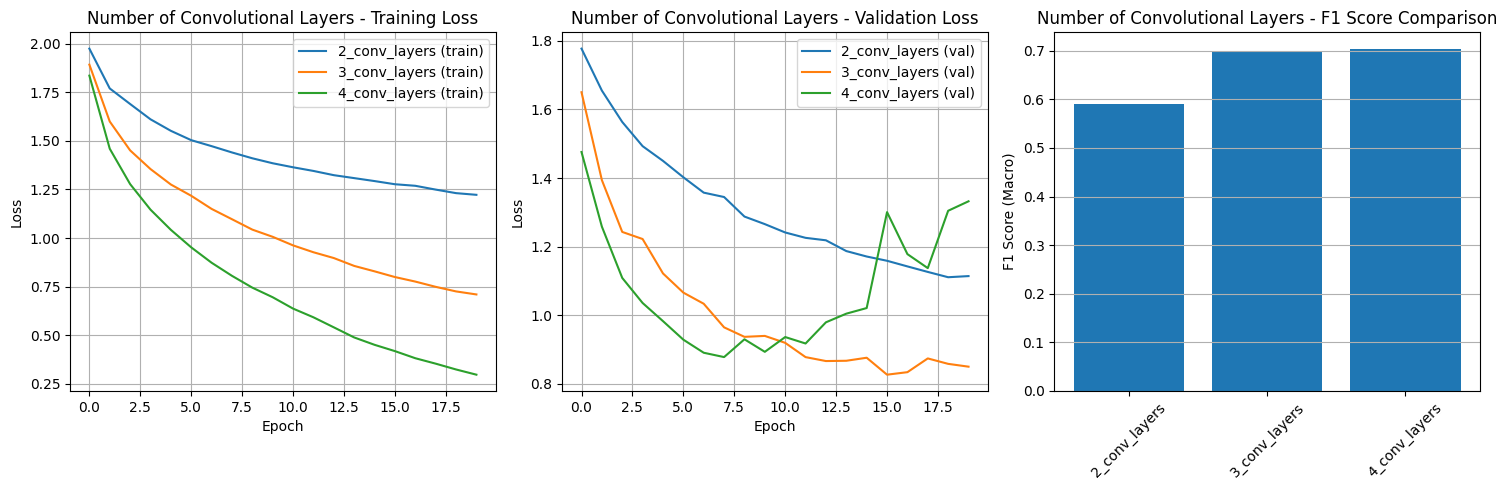

Training loss, validation loss, and f1 scores were already saved to: plots/conv_layers_comparison.png
EXPERIMENT 2: Effect of Number of Filters per Layer

Training model: small_filters
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2081 - loss: 2.0729 - val_accuracy: 0.3965 - val_loss: 1.6127
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3816 - loss: 1.6423 - val_accuracy: 0.4705 - val_loss: 1.4213
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4443 - loss: 1.5036 - val_accuracy: 0.5123 - val_loss: 1.3155
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4871 - loss: 1.4045 - val_accuracy: 0.5368 - val_loss: 1.2609
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5138 - loss: 1.3458 - val_accuracy: 0.5621 - val_loss: 1.2030
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5343 - loss: 1.2898 - val_accuracy: 0.5768 - val_loss: 1.1635
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━

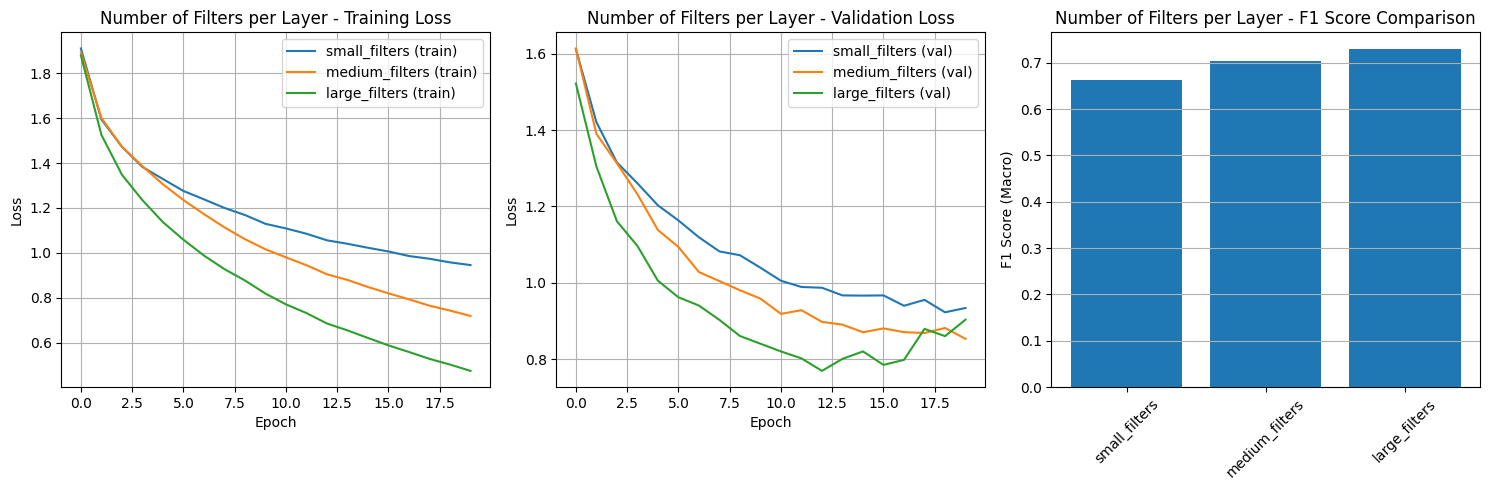

Training loss, validation loss, and f1 scores were already saved to: plots/num_filters_comparison.png
EXPERIMENT 3: Effect of Filter Sizes

Training model: small_kernels
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2092 - loss: 2.0733 - val_accuracy: 0.4189 - val_loss: 1.5633
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3976 - loss: 1.6100 - val_accuracy: 0.5025 - val_loss: 1.3510
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4807 - loss: 1.4322 - val_accuracy: 0.5466 - val_loss: 1.2299
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5211 - loss: 1.3246 - val_accuracy: 0.5844 - val_loss: 1.1496
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5572 - loss: 1.2373 - val_accuracy: 0.6131 - val_loss: 1.0862
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5828 - loss: 1.1709 - val_accuracy: 0.6158 - val_loss: 1.0789
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/s

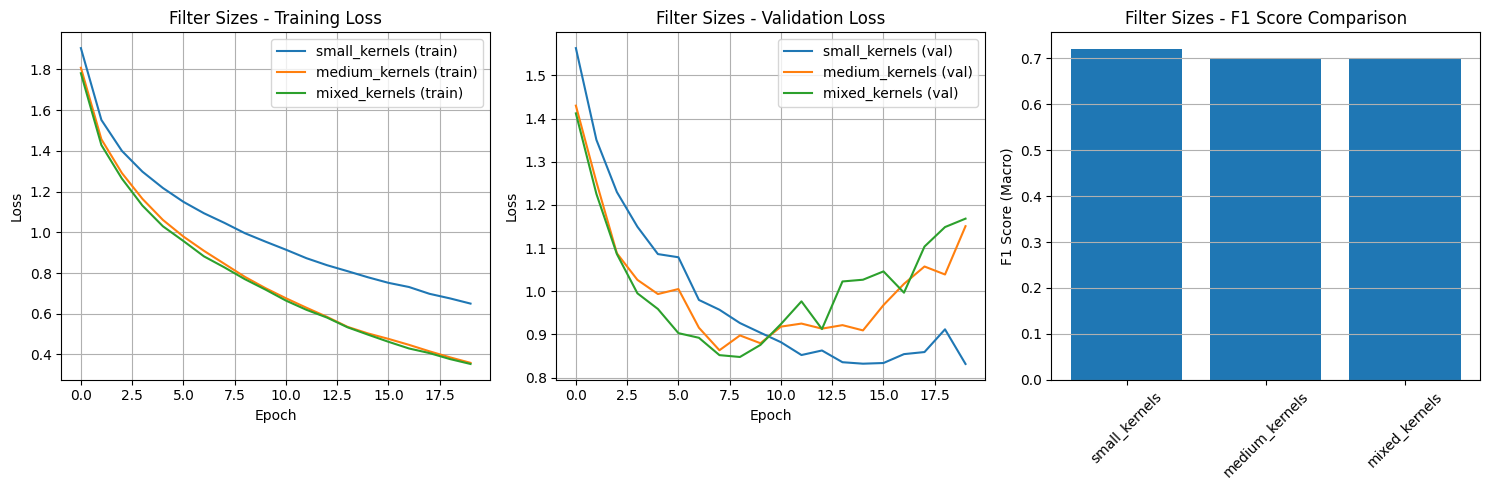

Training loss, validation loss, and f1 scores were already saved to: plots/filter_sizes_comparison.png
EXPERIMENT 4: Effect of Pooling Layer Types

Training model: max_pooling
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2133 - loss: 2.0597 - val_accuracy: 0.4210 - val_loss: 1.5780
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3910 - loss: 1.6354 - val_accuracy: 0.4998 - val_loss: 1.3565
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4652 - loss: 1.4604 - val_accuracy: 0.5342 - val_loss: 1.2551
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5104 - loss: 1.3566 - val_accuracy: 0.5626 - val_loss: 1.1949
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5412 - loss: 1.2791 - val_accuracy: 0.5960 - val_loss: 1.1164
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5677 - loss: 1.2077 - val_accuracy: 0.6143 - val_loss: 1.0604
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s

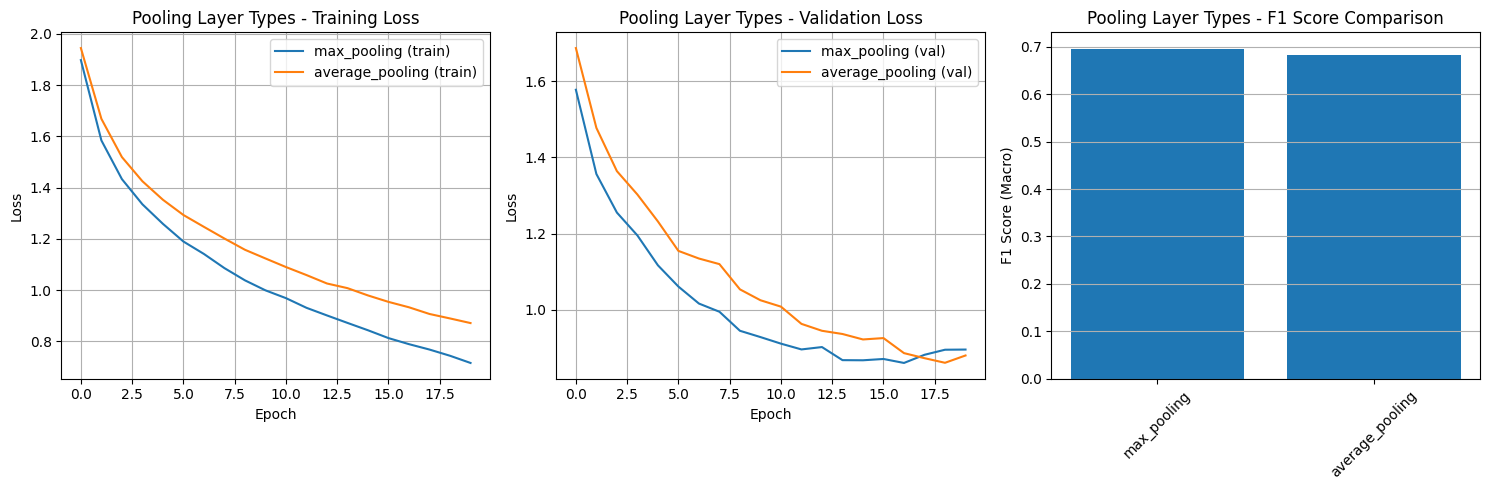

Training loss, validation loss, and f1 scores were already saved to: plots/pooling_types_comparison.png
Experiment results saved to: experiment_results.json
EXPERIMENT RESULTS SUMMARY

CONV LAYERS EXPERIMENT:
2_conv_layers        | F1: 0.5898 | Acc: 0.5926
3_conv_layers        | F1: 0.7004 | Acc: 0.7005
4_conv_layers        | F1: 0.7026 | Acc: 0.7007

NUM FILTERS EXPERIMENT:
small_filters        | F1: 0.6622 | Acc: 0.6616
medium_filters       | F1: 0.7036 | Acc: 0.7016
large_filters        | F1: 0.7294 | Acc: 0.7256

FILTER SIZES EXPERIMENT:
small_kernels        | F1: 0.7206 | Acc: 0.7199
medium_kernels       | F1: 0.7016 | Acc: 0.6980
mixed_kernels        | F1: 0.7016 | Acc: 0.6988

POOLING TYPES EXPERIMENT:
max_pooling          | F1: 0.6958 | Acc: 0.6940
average_pooling      | F1: 0.6822 | Acc: 0.6826


In [33]:
# 2. Run hyperparameter experiments
print("\nStep 2: Running hyperparameter experiments and saving the weights and architecture...")
experiments = CNNExperiments(data_splits)
experiments.run_all_experiments()

In [37]:
# 3. Test CNN custom forward propagation
print("\nStep 3: Testing CNN custom forward propagation...")
test_cnn_custom_forward_propagation()

print("Finished...")
print("- Models saved in 'models/' folder")
print("- Plots saved in 'plots/' folder")
print("- Results saved in 'experiment_results.json'")


Step 3: Testing CNN custom forward propagation...
TESTING CUSTOM FORWARD PROPAGATION
Loading the CIFAR-10 dataset from keras
Keras F1 Score: 0.6980
Custom F1 Score: 0.6980
The custom forward propagation MATCH keras forward propagation.
Finished...
- Models saved in 'models/' folder
- Plots saved in 'plots/' folder
- Results saved in 'experiment_results.json'
